In [4]:
import pandas as pd
import numpy as np
import pickle
from ase import Atoms
from dscribe.descriptors import ACSF
from sklearn.decomposition import PCA

In [ ]:
Atoms(symbols,positions)

In [2]:
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')
structures = pd.read_csv('../Data/structures.csv')
train_bonds = pd.read_csv('../Data/train_bonds.csv')
test_bonds = pd.read_csv('../Data/test_bonds.csv')

In [3]:
test_bonds = test_bonds.drop('Unnamed: 0',1)
train_bonds = train_bonds.drop('Unnamed: 0',1)

In [ ]:
train.head(10)

In [ ]:
structures.head()

In [ ]:
train_bonds.head()

In [ ]:
test_bonds.head()

### node information

In [4]:
structures[['C', 'F', 'H', 'N', 'O']] = pd.get_dummies(structures.atom)
structures = structures.sort_values(by=['molecule_name', 'atom_index'])

In [5]:
structures_gb = structures.groupby(['molecule_name'])

In [6]:
structures_list = []
mol_list = []
for k,v in structures_gb:
    atom_dict = {'positions':v[['x','y','z']].values.tolist(),
                 'symbols':[i[0] for i in v[['atom']].values.tolist()]
                 }
    atom = Atoms(**atom_dict)
    dist = atom.get_all_distances()
    d = dist.shape[0]
    dist = dist[np.tril_indices(d,-1)]
    r_info = np.array([dist.max(),dist.min(),dist.mean(),dist.std()])
    
    acsf = ACSF(species=['C', 'F', 'H', 'N', 'O'],
                rcut=r_info[0]+0.5,
                g2_params=[[1, 1], [1, 2], [1, 3], [2, 1], [2, 2], [2, 3]],
                g4_params=[[1, 1, 1], [1, 2, 1], [1, 1, -1], [1, 2, -1],\
                           [2, 1, 1], [2, 2, 1], [2, 1, -1], [2, 2, -1]])
    acsf_np = acsf.create(atom)
    temp = np.concatenate([acsf_np,v[['C', 'F', 'H', 'N', 'O']].values,\
                                         np.tile(r_info,(d,1))],1)
    structures_list.append(temp)
    mol_list.extend([k] * temp.shape[0])

In [7]:
structures_list = np.concatenate(structures_list,0)

In [8]:
mol_list = np.array(mol_list)

In [30]:
model = PCA(128,svd_solver='randomized',whiten=True)
structures_pca = model.fit_transform(structures_list)

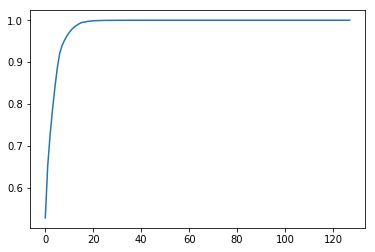

In [36]:
import matplotlib.pyplot as plt
plt.plot(model.explained_variance_ratio_.cumsum())

In [26]:
model = PCA(32,svd_solver='randomized',whiten=True)
structures_pca = model.fit_transform(structures_list)

In [27]:
model.explained_variance_ratio_.sum()

0.9999291292691276

In [54]:
structures_pca = structures_pca.astype(np.float32)

### bond information

In [24]:
structures.shape

(2358657, 164)

In [ ]:
assert set(train_bonds.bond_type) == set(test_bonds.bond_type)

In [33]:
bonds = train_bonds.append(test_bonds, ignore_index=True)

In [34]:
del train_bonds,test_bonds

In [35]:
bonds[['1.0CC',
 '1.0CF',
 '1.0CH',
 '1.0CN',
 '1.0CO',
 '1.0HN',
 '1.0HO',
 '1.0NN',
 '1.0NO',
 '1.5CO',
 '2.0CC',
 '2.0CN',
 '2.0CO',
 '2.0NN',
 '2.0NO',
 '3.0CC',
 '3.0CN']] = pd.get_dummies(bonds.bond_type)

In [36]:
bonds.head()

,molecule_name,atom_index_0,atom_index_1,nbond,L2dist,error,bond_type,1.0CC,1.0CF,1.0CH,...,1.0NN,1.0NO,1.5CO,2.0CC,2.0CN,2.0CO,2.0NN,2.0NO,3.0CC,3.0CN
0,dsgdb9nsd_000001,0,1,1.0,1.091953,0,1.0CH,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,dsgdb9nsd_000001,0,2,1.0,1.091952,0,1.0CH,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,dsgdb9nsd_000001,0,3,1.0,1.091946,0,1.0CH,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,dsgdb9nsd_000001,0,4,1.0,1.091948,0,1.0CH,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,dsgdb9nsd_000002,0,1,1.0,1.017190,0,1.0HN,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
bonds_gb = bonds.groupby(['molecule_name'])

In [38]:
bonds_edge_index = {}
bonds_edge_attr = {}
for k,v in bonds_gb:
    bonds_edge_index[k] = np.concatenate([v[['atom_index_0','atom_index_1']].values,\
                                          v[['atom_index_1','atom_index_0']].values]).T
    bonds_edge_attr[k] = np.tile(v[['L2dist', 'error',\
                                   '1.0CC', '1.0CF', '1.0CH', '1.0CN', '1.0CO','1.0HN',\
                                   '1.0HO', '1.0NN', '1.0NO', '1.5CO', '2.0CC', '2.0CN',\
                                   '2.0CO', '2.0NN', '2.0NO', '3.0CC', '3.0CN']].values.astype(np.float32),(2,1))

### coupling information

In [ ]:
assert set(train.type) == set(test.type)

In [39]:
test['scalar_coupling_constant'] = np.nan

In [40]:
coupling = train.append(test, ignore_index=True)

In [41]:
coupling.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [42]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

In [48]:
coupling = map_atom_info(coupling, 0)
coupling = map_atom_info(coupling, 1)

In [49]:
coupling = coupling.drop(['atom_0', 'C_x', 'F_x',
                          'H_x', 'N_x', 'O_x', 'atom_1','C_y', 'F_y', 'H_y',
                          'N_y', 'O_y'], axis=1)

In [50]:
train_p_0 = coupling[['x_0', 'y_0', 'z_0']].values
train_p_1 = coupling[['x_1', 'y_1', 'z_1']].values
coupling['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)

In [51]:
coupling[['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN']]=pd.get_dummies(coupling.type)

In [52]:
coupling = coupling.groupby(['molecule_name'])

In [53]:
coupling_edge_index = {}
coupling_edge_attr = {}
coupling_edge_dist = {}
coupling_y = {}
for k,v in coupling:
    coupling_edge_index[k] = v[['atom_index_0','atom_index_1']].values.T
    coupling_edge_attr[k] = v[['1JHC','1JHN','2JHC','2JHH','2JHN','3JHC','3JHH','3JHN']].values.astype(np.float32)
    coupling_edge_dist[k] = v[['dist']].values.astype(np.float32)
    if not np.any(np.isnan(v.scalar_coupling_constant.values)):
        coupling_y[k] = v.scalar_coupling_constant.values.astype(np.float32)

In [55]:
train_mol = np.unique(train.molecule_name)
test_mol = np.unique(test.molecule_name)

In [56]:
train_mol = np.random.permutation(train_mol)

In [57]:
train_mol2 = train_mol[:70000]
val_mol = train_mol[70000:]
train_mol = train_mol2

In [58]:
train_data = [{'x':structures_pca[mol_list==m],'edge_index':bonds_edge_index[m],\
               'edge_attr':bonds_edge_attr[m],'y':coupling_y[m],\
               'edge_index3':coupling_edge_index[m],'edge_attr3':coupling_edge_attr[m],\
               'edge_attr4':coupling_edge_dist[m]}
              for m in train_mol]

In [59]:
val_data = [{'x':structures_pca[mol_list==m],'edge_index':bonds_edge_index[m],\
               'edge_attr':bonds_edge_attr[m],'y':coupling_y[m],\
               'edge_index3':coupling_edge_index[m],'edge_attr3':coupling_edge_attr[m],\
               'edge_attr4':coupling_edge_dist[m]}
              for m in val_mol]

In [60]:
test_data = [{'x':structures_pca[mol_list==m],'edge_index':bonds_edge_index[m],\
               'edge_attr':bonds_edge_attr[m],\
               'edge_index3':coupling_edge_index[m],'edge_attr3':coupling_edge_attr[m],\
               'edge_attr4':coupling_edge_dist[m]}
              for m in test_mol]

In [61]:
with open('../Data/train_data_ACSF_PCA.pickle', 'wb') as handle:
    pickle.dump(train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../Data/val_data_ACSF_PCA.pickle', 'wb') as handle:
    pickle.dump(val_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../Data/test_data_ACSF_PCA.pickle', 'wb') as handle:
    pickle.dump(test_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
with open('../Data/train_data_ACSF_PCA.pickle', 'rb') as handle:
    train_data = pickle.load(handle)
with open('../Data/val_data_ACSF_PCA.pickle', 'rb') as handle:
    val_data = pickle.load(handle)
with open('../Data/test_data_ACSF_PCA.pickle', 'rb') as handle:
    test_data = pickle.load(handle)

In [6]:
# convert numpy array to torch array
import torch
train_data = [{k:torch.tensor(i[k]) for k in i.keys()} for i in train_data]
val_data = [{k:torch.tensor(i[k]) for k in i.keys()} for i in val_data]
test_data = [{k:torch.tensor(i[k]) for k in i.keys()} for i in test_data]

In [7]:
with open('../Data/train_data_ACSF_PCA.pickle', 'wb') as handle:
    pickle.dump(train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../Data/val_data_ACSF_PCA.pickle', 'wb') as handle:
    pickle.dump(val_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../Data/test_data_ACSF_PCA.pickle', 'wb') as handle:
    pickle.dump(test_data, handle, protocol=pickle.HIGHEST_PROTOCOL)